In [2]:
# general
import sys, os, path
import datetime

# nn related
import torch as th
import torch.nn as nn
import numpy as np
# from numpy import linalg as la
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
import seaborn as sns
import tikzplotlib as tikz
from scipy import ndimage
import matplotlib as mpl
from matplotlib.transforms import Bbox

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *

# standard datatype
dtype = th.double

In [3]:
# read in tensor data
rans_path = '/home/leonriccius/Documents/Fluid_Data/rans_kaandorp/PeriodicHills/Re5600_kOmega_150'

rans_time = max([int(entry) for entry in os.listdir(rans_path) if entry.isnumeric()])
# rans_time = '30000'

with NoStdStreams():
    grid = pre.readCellCenters(rans_time, rans_path)
    rs = pre.readSymTensorData(rans_time, 'R', rans_path).reshape(-1, 3, 3)
    grad_u = pre.readTensorData(rans_time, 'grad(U)', rans_path)
    grad_k = pre.readVectorData(rans_time, 'grad(k)', rans_path)
    grad_p = pre.readVectorData(rans_time, 'grad(p)', rans_path)
    y_wall = pre.readScalarData(rans_time, 'yWall', rans_path)
    k = pre.readScalarData(rans_time, 'k', rans_path)
    omega = pre.readScalarData(rans_time, 'omega', rans_path)  # 'epsilon' or 'omega'
    epsilon = omega * k * 0.09  # 0.09 is beta star
    nu = 3.5714285714285714e-04

# get b_rans
b_rans = barymap.anisotropy(rs, k)

# calculate mean rate of strain and rotation tensors
s = 0.5 * (grad_u + grad_u.transpose(1, 2))
r = 0.5 * (grad_u - grad_u.transpose(1, 2))

# normalize s and r
s_hat = (k / epsilon).unsqueeze(1).unsqueeze(2) * s
r_hat = (k / epsilon).unsqueeze(1).unsqueeze(2) * r
grad_k_hat = (th.sqrt(k) / epsilon).unsqueeze(1) * grad_k

# capping tensors
s_hat = cap_tensor(s_hat, 6.0)
r_hat = cap_tensor(r_hat, 6.0)

inv = get_invariants(s_hat, r_hat)

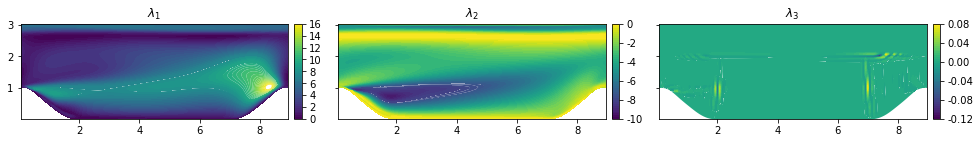

In [4]:
# define refinement level of interpolation grid and how much of boundary should be but off
ref = 15
gamma = 0.995

# find min an max of x coordinate
x_min, x_max = np.min(grid[:,0].numpy()), np.max(grid[:,0].numpy())
x_mean = 0.5*(x_max - x_min)
x_min = x_mean - gamma*(x_mean - x_min)
x_max = x_mean - gamma*(x_mean - x_max)

# find min and max of y coordinate
y_min, y_max = np.min(grid[:,1].numpy()), np.max(grid[:,1].numpy())
y_mean = 0.5*(y_max - y_min)
y_min = y_mean - gamma*(y_mean - y_min)
y_max = y_mean - gamma*(y_mean - y_max)

# compute number of points per coordinate
np_x = int(ref*(x_max - x_min))
np_y = int(ref*(y_max - y_min))

# get grid and shift points on curved boundaries
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, np_x), np.linspace(y_min, y_max, np_y))
grid_y_shifted = ph_interp(grid_x)*(y_max - grid_y)/y_max + grid_y
grid_y = grid_y_shifted

# interpolate invariants
grid_inv = griddata(grid[:,0:2], inv.numpy(), (grid_x, grid_y), method = 'linear') #, fill_value=0.)

# get min an max of (b_pred, b_test) for colormap
inv_min = np.min(grid_inv, axis=(0,1))
inv_max = np.max(grid_inv, axis=(0,1))

ncols = 3
nrows = 1
s = 1.5

# # # create figure
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*3.*ncols, s*1.25*nrows), sharex=True, sharey=True,
                       constrained_layout=True)   # set factor for ncols to 4.5 for true scaling of physical domain
    
levels = np.linspace(inv_min, inv_max, 50)

inv_1 = ax1[0].contourf(grid_x, grid_y_shifted, grid_inv[:,:,0], levels = np.linspace(0,16,50))
inv_2 = ax1[1].contourf(grid_x, grid_y_shifted, grid_inv[:,:,1], levels = np.linspace(-10,0,50))
inv_3 = ax1[2].contourf(grid_x, grid_y_shifted, grid_inv[:,:,2], levels = np.linspace(-0.12, 0.08, 50))
# inv_4 = ax1[3].contourf(grid_x, grid_y_shifted, grid_inv[:,:,3], levels = levels[:,3])
# inv_5 = ax1[4].contourf(grid_x, grid_y_shifted, grid_inv[:,:,4], levels = levels[:,4])
    
# remove contour lines
for contour in [inv_1, inv_2, inv_3]:
    for c in contour.collections:
        c.set_edgecolor("face")
        c.set_linewidth(0.000000000000000000001)
        
# get colorbars
fig1.colorbar(inv_1, ax=ax1[0], aspect=10*nrows*ncols*3, format='%.f', pad=0.0, ticks=np.arange(0,17,2))
fig1.colorbar(inv_2, ax=ax1[1], aspect=10*nrows*ncols*3, format='%.f', pad=0.0, ticks=np.arange(-10,1,2))
fig1.colorbar(inv_3, ax=ax1[2], aspect=10*nrows*ncols*3, format='%.2f', pad=0.0, ticks=np.linspace(-0.12, 0.08, 6))
ax1[0].set_title(r'$\lambda_1$')
ax1[1].set_title(r'$\lambda_2$')
ax1[2].set_title(r'$\lambda_3$')

# render figure
fig1.canvas.draw()

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/methodology'
# fig1.savefig(os.sep.join([fig_path, 'input_features_inv_123_phill_5600.pdf']) , format='pdf')
# fig1.savefig(os.sep.join([fig_path, 'input_features_inv_1_phill_5600']) , format='png', bbox_inches=extent_inv1)

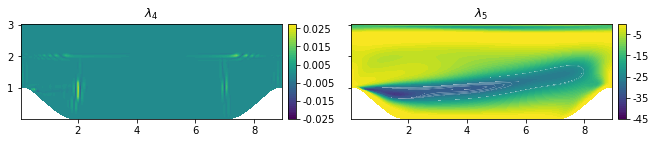

In [5]:
ncols = 2
nrows = 1

# # # create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*3.*ncols, s*1.25*nrows), sharex=True, sharey=True,
                       constrained_layout=True)   # set factor for ncols to 4.5 for true scaling of physical domain
    
levels = np.linspace(inv_min, inv_max, 50)

inv_4 = ax[0].contourf(grid_x, grid_y_shifted, grid_inv[:,:,3], levels = np.linspace(-0.025, 0.0275, 50))
inv_5 = ax[1].contourf(grid_x, grid_y_shifted, grid_inv[:,:,4], levels = np.linspace(-45, 0, 50))
    
# remove contour lines
for contour in [inv_4, inv_5]:
    for c in contour.collections:
        c.set_edgecolor("face")
        c.set_linewidth(0.000000000000000000001)

# get colorbars
fig.colorbar(inv_4, ax=ax[0], aspect=10*nrows*ncols*3, format='%.3f', pad=0.0, ticks=np.arange(-0.025, 0.0275, 0.01))
fig.colorbar(inv_5, ax=ax[1], aspect=10*nrows*ncols*3, format='%.f', pad=0.0, ticks=np.arange(-45,0.001,10))
ax[0].set_title(r'$\lambda_4$')
ax[1].set_title(r'$\lambda_5$')

# render figure
fig.canvas.draw()

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/methodology'
# fig.savefig(os.sep.join([fig_path, 'input_features_inv_45_phill_5600.pdf']) , format='pdf')

<ipython-input-23-686f82452b56>:42: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig1.subplots_adjust(wspace=0.14, hspace=0.2)


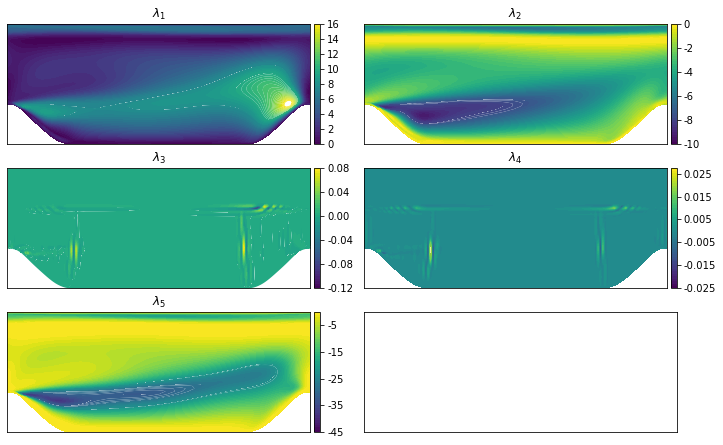

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# define refinement level of interpolation grid and how much of boundary should be but off
ref = 15
gamma = 0.995

# find min an max of x coordinate
x_min, x_max = np.min(grid[:,0].numpy()), np.max(grid[:,0].numpy())
x_mean = 0.5*(x_max - x_min)
x_min = x_mean - gamma*(x_mean - x_min)
x_max = x_mean - gamma*(x_mean - x_max)

# find min and max of y coordinate
y_min, y_max = np.min(grid[:,1].numpy()), np.max(grid[:,1].numpy())
y_mean = 0.5*(y_max - y_min)
y_min = y_mean - gamma*(y_mean - y_min)
y_max = y_mean - gamma*(y_mean - y_max)

# compute number of points per coordinate
np_x = int(ref*(x_max - x_min))
np_y = int(ref*(y_max - y_min))

# get grid and shift points on curved boundaries
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, np_x), np.linspace(y_min, y_max, np_y))
grid_y_shifted = ph_interp(grid_x)*(y_max - grid_y)/y_max + grid_y
grid_y = grid_y_shifted

# interpolate invariants
grid_inv = griddata(grid[:,0:2], inv.numpy(), (grid_x, grid_y), method = 'linear') #, fill_value=0.)

# get min an max of (b_pred, b_test) for colormap
inv_min = np.min(grid_inv, axis=(0,1))
inv_max = np.max(grid_inv, axis=(0,1))

ncols = 2
nrows = 3
s = 2.

# # # create figure
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*3.*ncols, s*1.25*nrows), sharex=True, sharey=True,
                         constrained_layout=True)   # set factor for ncols to 4.5 for true scaling of physical domain
fig1.subplots_adjust(wspace=0.14, hspace=0.2)
    
levels = np.linspace(inv_min, inv_max, 50)

inv_1 = ax1[0,0].contourf(grid_x, grid_y_shifted, grid_inv[:,:,0], levels = np.linspace(0,16,50))
inv_2 = ax1[0,1].contourf(grid_x, grid_y_shifted, grid_inv[:,:,1], levels = np.linspace(-10,0,50))
inv_3 = ax1[1,0].contourf(grid_x, grid_y_shifted, grid_inv[:,:,2], levels = np.linspace(-0.12, 0.08, 50))
inv_4 = ax1[1,1].contourf(grid_x, grid_y_shifted, grid_inv[:,:,3], levels = np.linspace(-0.025, 0.0275, 50))
inv_5 = ax1[2,0].contourf(grid_x, grid_y_shifted, grid_inv[:,:,4], levels = np.linspace(-45, 0, 50))

divider1 = make_axes_locatable(ax1[0,0])
cax1 = divider1.new_horizontal(size='2%', pad=0.05)
fig1.add_axes(cax1)

divider2 = make_axes_locatable(ax1[0,1])
cax2 = divider2.new_horizontal(size='2%', pad=0.05)
fig1.add_axes(cax2)

divider3 = make_axes_locatable(ax1[1,0])
cax3 = divider3.new_horizontal(size='2%', pad=0.05)
fig1.add_axes(cax3)

divider4 = make_axes_locatable(ax1[1,1])
cax4 = divider4.new_horizontal(size='2%', pad=0.05)
fig1.add_axes(cax4)

divider5 = make_axes_locatable(ax1[2,0])
cax5 = divider5.new_horizontal(size='2%', pad=0.05)
fig1.add_axes(cax5)

# remove contour lines
for contour in [inv_1, inv_2, inv_3, inv_4, inv_5]:
    for c in contour.collections:
        c.set_edgecolor("face")
        c.set_linewidth(0.000000000000000000001)
        
# get colorbars
fig1.colorbar(inv_1, cax=cax1, format='%.f', ticks=np.arange(0,17,2))
fig1.colorbar(inv_2, cax=cax2, format='%.f', ticks=np.arange(-10,1,2))
fig1.colorbar(inv_3, cax=cax3, format='%.2f', ticks=np.linspace(-0.12, 0.08, 6))
fig1.colorbar(inv_4, cax=cax4, format='%.3f', ticks=np.arange(-0.025, 0.0275, 0.01))
fig1.colorbar(inv_5, cax=cax5, format='%.f', ticks=np.arange(-45,0.001,10))
ax1[0,0].set_title(r'$\lambda_1$')
ax1[0,1].set_title(r'$\lambda_2$')
ax1[1,0].set_title(r'$\lambda_3$')
ax1[1,1].set_title(r'$\lambda_4$')
ax1[2,0].set_title(r'$\lambda_5$')

for ax in ax1.flat:
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)

# render figure
fig1.canvas.draw()

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/methodology/invariants_3rows'
# fig1.savefig(os.sep.join([fig_path, 'inputFeatures_invAll_noLabels_phill5600.pdf']) , format='pdf')
# fig1.savefig(os.sep.join([fig_path, 'input_features_inv_1_phill_5600']) , format='png', bbox_inches=extent_inv1)

<ipython-input-7-f9538494dc12>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig1.subplots_adjust(wspace=0.18)


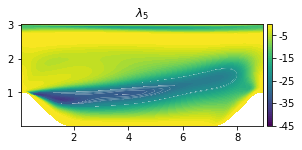

In [7]:
ncols = 1
nrows = 1
s = 1.5

# create figure
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*3.*ncols, s*1.25*nrows), sharex=True, sharey=True,
                         constrained_layout=True)   # set factor for ncols to 4.5 for true scaling of physical domain
fig1.subplots_adjust(wspace=0.18)
    
levels = np.linspace(inv_min, inv_max, 50)

inv_5 = ax1.contourf(grid_x, grid_y_shifted, grid_inv[:,:,4], levels = np.linspace(-45, 0, 50))

divider1 = make_axes_locatable(ax1)
cax1 = divider1.new_horizontal(size='2%', pad=0.05)
fig1.add_axes(cax1)

# remove contour lines
for contour in [inv_5]:
    for c in contour.collections:
        c.set_edgecolor("face")
        c.set_linewidth(0.000000000000000000001)
        
# get colorbars
fig1.colorbar(inv_5, cax=cax1, format='%.f', ticks=np.arange(-45,0.001,10))
ax1.set_title(r'$\lambda_5$')

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/methodology/invariants_3rows'
# fig1.savefig(os.sep.join([fig_path, 'input_features_inv_5_phill_5600.pdf']) , format='pdf')